# Setup & model load

In [25]:
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay

# laod config
with open('../config/params.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
# load data: use the balanced version for better insights
df = pd.read_csv('../data/processed/btc_features_labeled.csv', index_col='time', parse_dates=True)

# it's needed to replicate the training one last time to have the 'model' object in memory
# or you can import your XGBoostTrainer class here
feature_cols = config['btc_trading']['features']['model_cols']
X = df[feature_cols]
y = df['label'] + 1 # convert to [0, 1, 2]

# manual split to match main.py logic
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

model = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=3, 
    learning_rate=0.05,
    objective='multi:softprob',
    random_state=42
)
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

# Feature Importance
## The "gold" insight
Indicates which indicator the model used most to identify the "cheap" moments.

/tmp/ipykernel_63742/883765426.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance, palette='viridis')


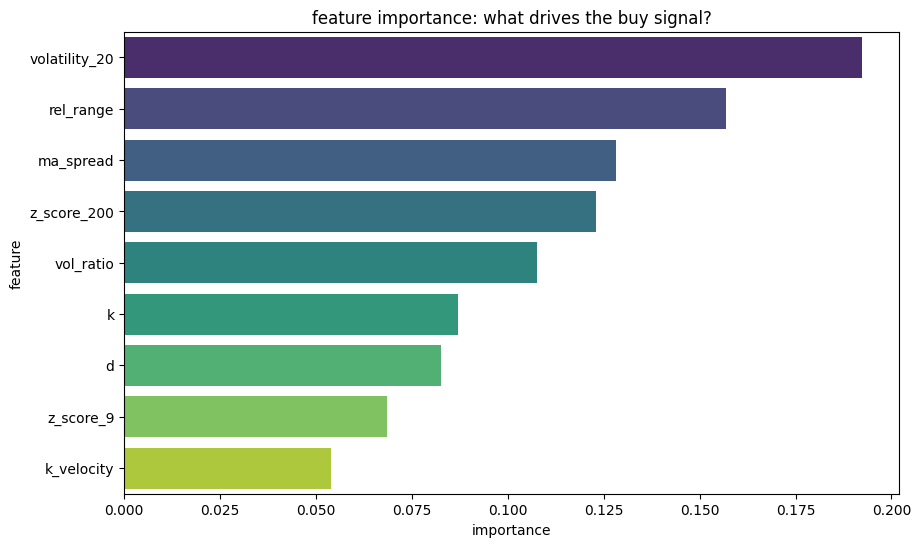

In [26]:
# extract feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance, palette='viridis')
plt.title('feature importance: what drives the buy signal?')
plt.show()

# Confusion Matrix
## The "risk" insight

Here we will see if, when the model misses the purchase (Label 1), it misses for "Timeout" (Label 0) or for "Loss" (Label -1).

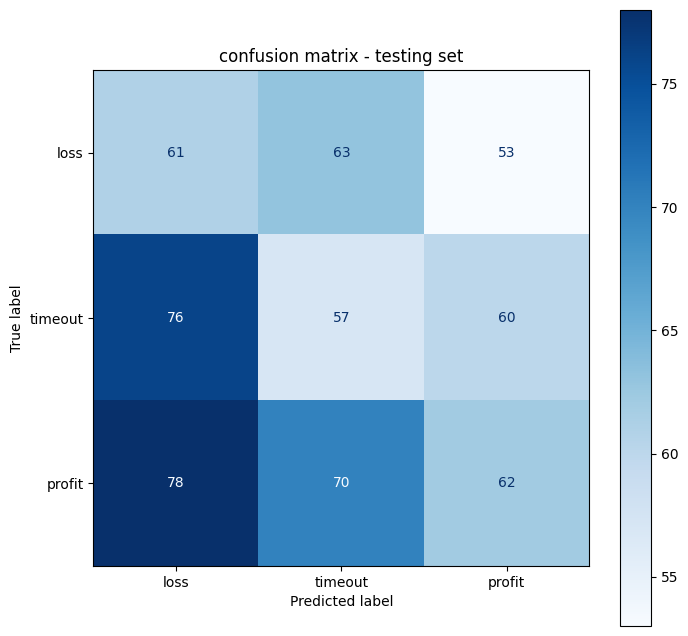

In [27]:
# predict on test set
y_pred = model.predict(X_test)

# display confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test - 1, 
    y_pred - 1, 
    display_labels=['loss', 'timeout', 'profit'],
    cmap='Blues',
    ax=ax
)
plt.title('confusion matrix - testing set')
plt.show()

In [28]:
# predict probabilities instead of classes
probs = model.predict_proba(X_test)

# column 2 is 'profit' (label 1), because our classes are [0, 1, 2] -> [-1, 0, 1]
profit_probs = probs[:, 2]

# create a mask for high confidence signals (e.g. > 60%)
high_conf_mask = profit_probs > 0.60
high_conf_preds = np.where(high_conf_mask, 1, 0) # simplified for analysis

print(f"trades found with >60% confidence: {high_conf_mask.sum()}")
# check if precision improved on these specific cases

trades found with >60% confidence: 12


# Probrability analysis
XGBoost does not simply decide between -1, 0, or 1. It calculates the probability of each. It's needed to find out if, when the model is more than 50% or 60% certain about Label 1, the accuracy rises to profitable levels (e.g., > 50%).

     Confidence Threshold Analysis 
   threshold  precision  trades
0       0.35   0.363208     212
1       0.40   0.380282     142
2       0.45   0.340909      88
3       0.50   0.283019      53
4       0.55   0.393939      33
5       0.60   0.333333      12


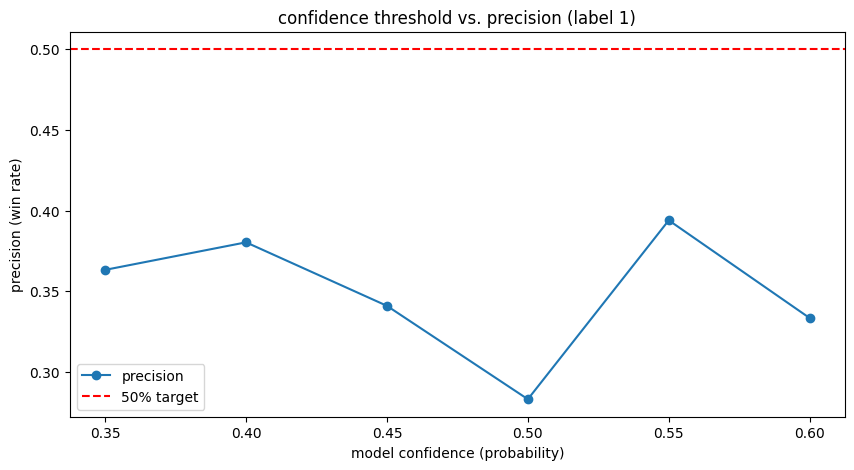

In [29]:
# 1. get probabilities for each class
# probs columns: [class_0, class_1, class_2] which corresponds to [-1, 0, 1]
probs = model.predict_proba(X_test)
df_probs = pd.DataFrame(probs, columns=['prob_loss', 'prob_timeout', 'prob_profit'], index=X_test.index)

# 2. analyze precision at different confidence thresholds
thresholds = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
results = []

for t in thresholds:
    # identify trades where confidence in profit is above threshold
    signals = df_probs[df_probs['prob_profit'] > t]
    
    if len(signals) > 0:
        # check how many of these signals actually resulted in profit (label 1)
        # remember y_test is [0, 1, 2], so profit is 2
        actual_outcomes = y_test.loc[signals.index]
        precision = (actual_outcomes == 2).mean()
        num_trades = len(signals)
        results.append({'threshold': t, 'precision': precision, 'trades': num_trades})

df_thresholds = pd.DataFrame(results)
print("     Confidence Threshold Analysis ")
print(df_thresholds)

# 3. visualize the trade-off
plt.figure(figsize=(10, 5))
plt.plot(df_thresholds['threshold'], df_thresholds['precision'], marker='o', label='precision')
plt.axhline(y=0.5, color='red', linestyle='--', label='50% target')
plt.title('confidence threshold vs. precision (label 1)')
plt.xlabel('model confidence (probability)')
plt.ylabel('precision (win rate)')
plt.legend()
plt.show()

# Real precision per Threshold

In [30]:
# predict probabilities
probs = model.predict_proba(X_test)

# index 2 corresponds to label 1 (profit)
profit_probs = probs[:, 2]

# let's see if precision increases with confidence
thresholds = [0.35, 0.40, 0.45, 0.50, 0.55]
for t in thresholds:
    mask = profit_probs > t
    if mask.sum() > 0:
        # filter actual outcomes where confidence was > t
        actuals = y_test[mask]
        # precision for label 1 (which is value 2 in y_test)
        precision = (actuals == 2).mean()
        print(f"threshold: {t:.2f} | precision: {precision:.2%} | trades: {mask.sum()}")

threshold: 0.35 | precision: 36.32% | trades: 212
threshold: 0.40 | precision: 38.03% | trades: 142
threshold: 0.45 | precision: 34.09% | trades: 88
threshold: 0.50 | precision: 28.30% | trades: 53
threshold: 0.55 | precision: 39.39% | trades: 33
